# <center>OPERATION ANALYTICS AND INVESTIGATING METRIC SPIKE

## IMPORTS AND CONNECTION

Importing packages and files

In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
from math import floor, ceil

from sql_credentials import SQL_CONFIG

Eastablishing connection to MySql Database

In [2]:
CONNECTION = mysql.connector.connect(**SQL_CONFIG)
CURSOR = CONNECTION.cursor(buffered=True)

warnings.filterwarnings('ignore')

## ANALYSIS

### Case Study 1 - Job Data

#### A. Number of jobs reviewed
Calculating number of jobs reviewed per hour per day for November 2020.

In [43]:
query = """
    SELECT ds AS Date, COUNT(*) / (SUM(time_spent)/3600) AS Jobs
    FROM job_data
    GROUP BY ds
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)
print(f"On an average, {floor(sql_df['Jobs'].mean())} to {ceil(sql_df['Jobs'].mean())} jobs are reviewed per hour per day for November 2020")

On an average, 126 to 127 jobs are reviewed per hour per day for November 2020


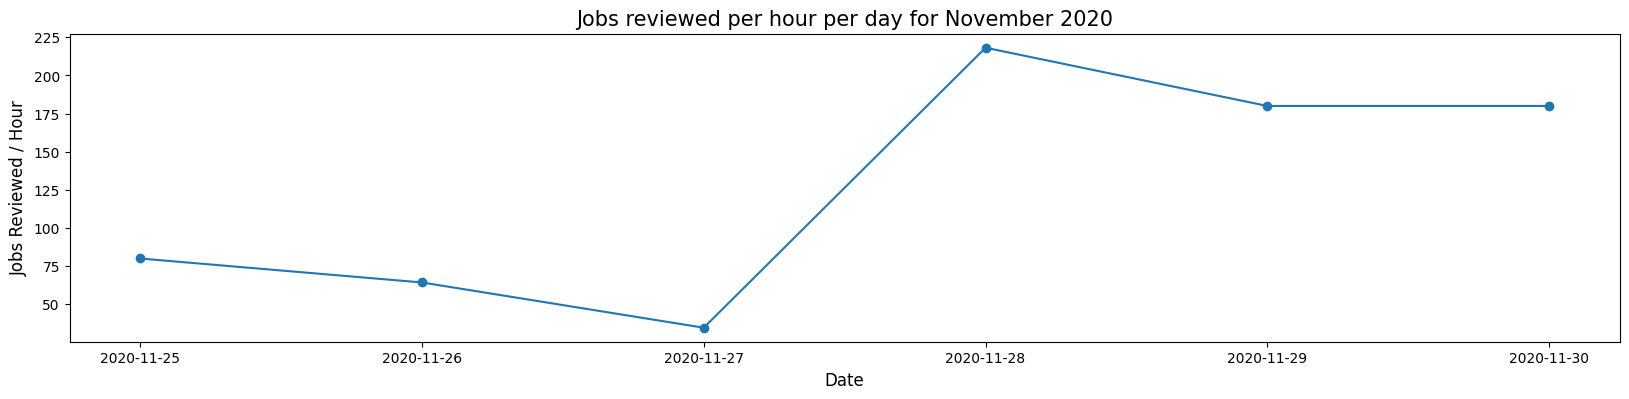

In [44]:
plt.figure(figsize=(20,4))
plt.title('Jobs reviewed per hour per day for November 2020', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Jobs Reviewed / Hour', fontsize=12)
plt.plot(sql_df['Date'], sql_df['Jobs'], marker='o')
plt.show()

#### B. Throughput
* Finding 7 day rolling average of throughput.
* Finding daily throughput.
* Comparing between daily and metric and 7 day rolling with reasoning.

In [46]:
query = """
    SELECT 
        ds AS Date, 
        COUNT(*)/SUM(time_spent) AS Thput,
        AVG(COUNT(*)/(SUM(time_spent))) OVER (ORDER BY ds ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Roll_Thput
    FROM job_data
    GROUP BY ds 
    ORDER BY ds
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

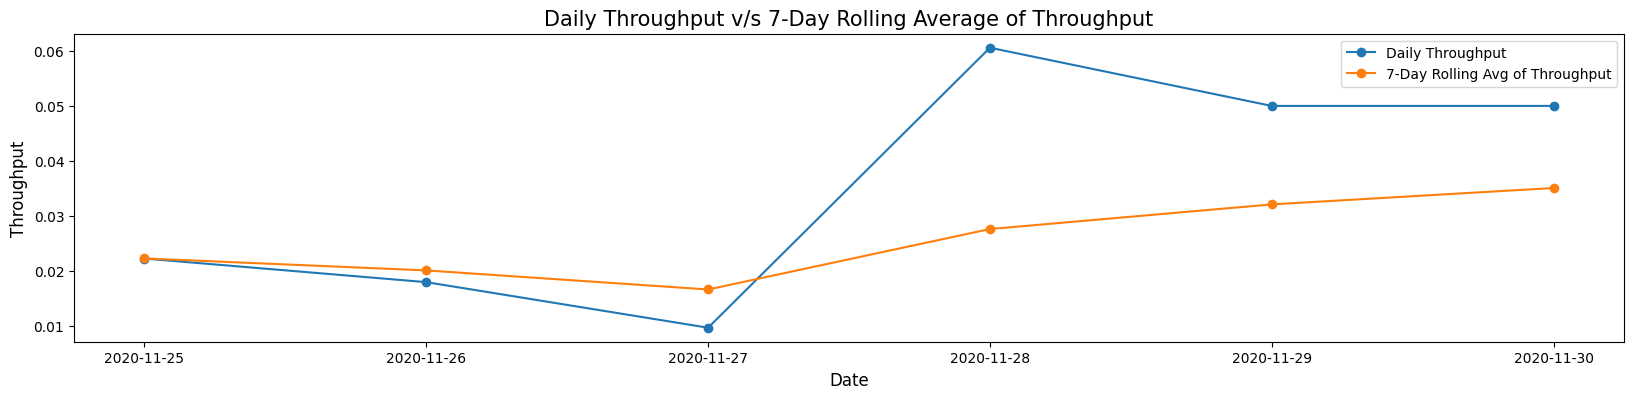

In [48]:
plt.figure(figsize=(20,4))
plt.title('Daily Throughput v/s 7-Day Rolling Average of Throughput', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Throughput', fontsize=12)
plt.plot(sql_df['Date'], sql_df['Thput'], label='Daily Throughput', marker='o')
plt.plot(sql_df['Date'], sql_df['Roll_Thput'], label='7-Day Rolling Avg of Throughput', marker='o')
plt.legend()
plt.show()

A 7-Day Rolling Average Metric should be prefered over the Daily Metric in the longer run, as:
* A 7-day rolling average helps to smooth out daily variations in throughput, providing a more consistent view of performance over time.
* Analyzing the 7-day rolling average of throughput makes it easier to identify underlying trends and patterns that may not be apparent when looking at daily metrics alone.
* A rolling average provides a more stable and predictable view of performance over time, which can help businesses to forecast demand and make informed decisions.

#### C. Percentage share of each language
Calculating the percentage share of each language in last 30 days.

In [7]:
# Sub-query to return the date which is 30 days back
sub_query = """
    SELECT DATE_SUB(MAX(ds), INTERVAL 30 DAY)
    FROM job_data
"""
# Sub-query to fetch total number of records from last 30 days
sub_query_02 = f"""
    SELECT COUNT(*)
    FROM job_data
    WHERE ds >= ({sub_query})
"""
# Fetching percent share of each language in the last 30 days
query = f"""
    SELECT
        language,
        COUNT(*) / ({sub_query_02})*100 AS per_share
    FROM job_data
    WHERE ds >= ({sub_query})
    GROUP BY language
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

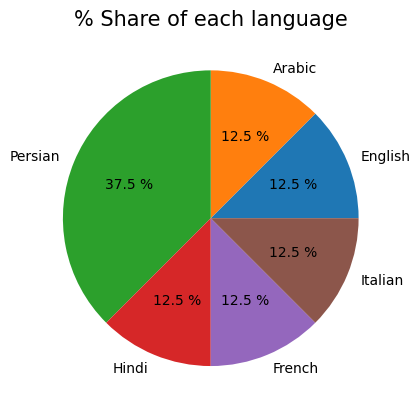

In [8]:
plt.title('% Share of each language', fontsize=15)
plt.pie(sql_df['per_share'], labels=sql_df['language'], autopct=lambda x: f"{x} %")
plt.show()

#### D. Duplicate rows
Finding duplicates in the table.

Let's consider a row will be called duplicate when:
* An actor has applied to the same job and in the same language
* Which means, values are same for the columns `actor_id`, `job_id` and `language`.

In [9]:
query = """
    SELECT job_id, actor_id, language, COUNT(*) As duplicates
    FROM job_data
    GROUP BY job_id, actor_id, language
    HAVING COUNT(*) > 1;
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)
sql_df.head()

,job_id,actor_id,language,duplicates


* The dataframe is empty indicating that there is no duplicate row.
* That means, all actors have only applied once to each job for a particular language content.

### Case Study 2 - Investigating Metric Spike

#### A. User Engagement
* Finding weekly user engagement.

In [40]:
# Fetching account creation date and number of images uploaded for each user
query = """
    SELECT
        WEEK(occurred_at) AS week_num, COUNT(DISTINCT user_id) AS users,
        SUM(event_name = 'login') AS logins
    FROM events
    WHERE event_type = 'engagement'
    group by week_num
    order by week_num
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

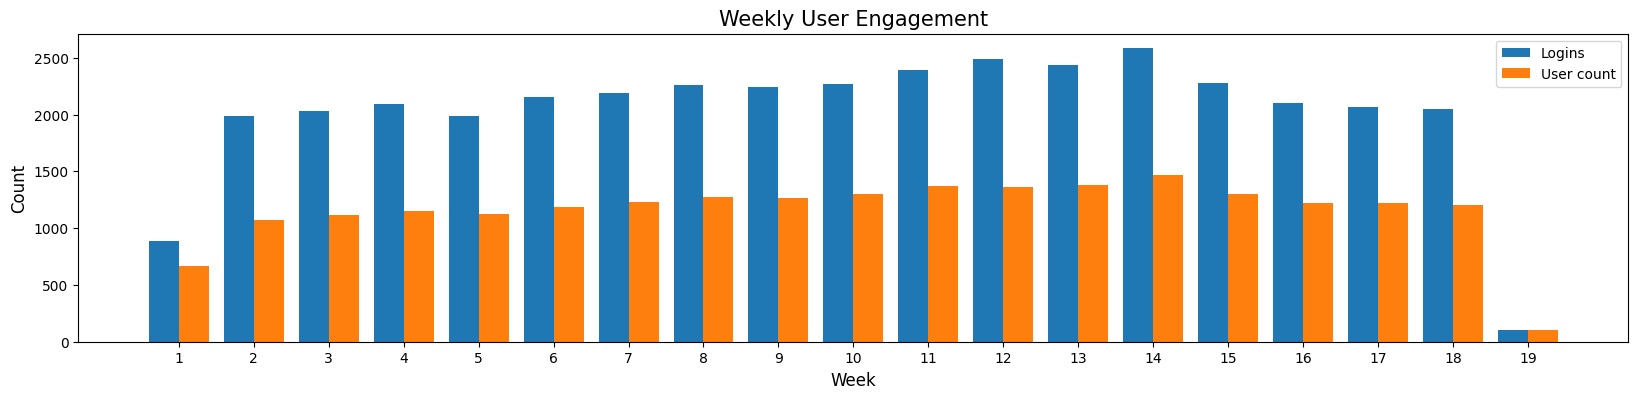

In [41]:
X_axis = np.arange(len(sql_df))
plt.figure(figsize=(20,4))
plt.title('Weekly User Engagement', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.bar(X_axis-0.2, sql_df['logins'], 0.4, label='Logins')
plt.bar(X_axis+0.2, sql_df['users'], 0.4, label='User count')
plt.xticks(X_axis, X_axis+1)
plt.legend()
plt.show()

#### B. User Growth
* Finding the user growth.

In [43]:
# Sub-query to date with number of new accounts
sub_query = """
    SELECT DATE(created_at) AS aod, COUNT(*) AS new_accts
	FROM users
    WHERE state = 'active'
	GROUP BY 1
"""
# Fetching date with number of new accounts and cumulative sum
query = f"""
	SELECT aod, new_accts, SUM(new_accts) OVER(ORDER BY aod) as cum_regs
	FROM ({sub_query}) a
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)
sql_df['aod'] = pd.to_datetime(sql_df['aod'])

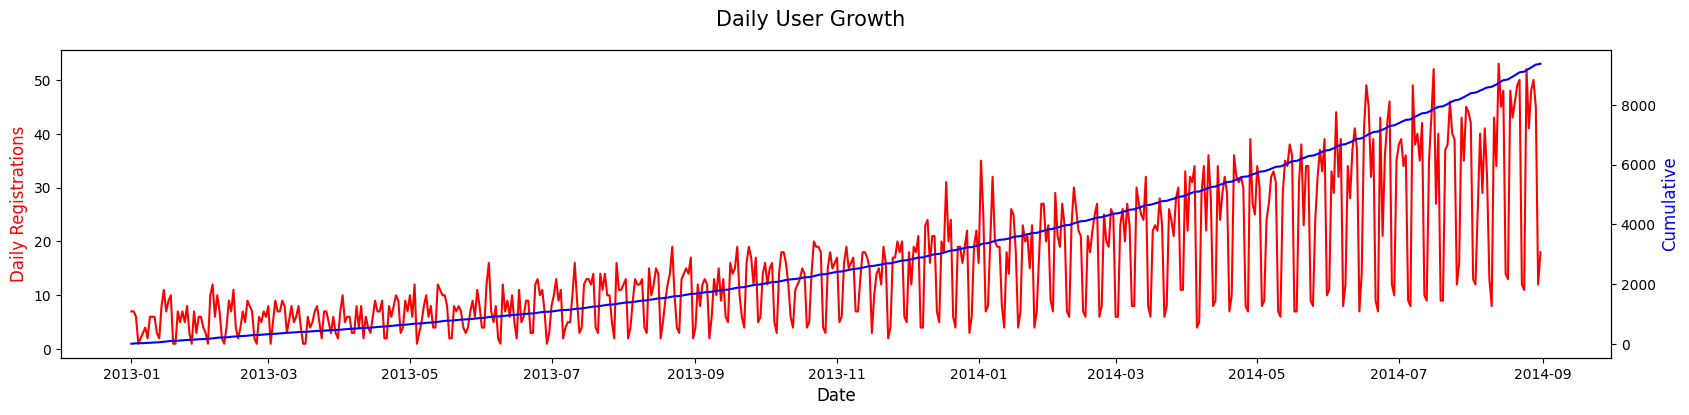

In [44]:
fig, ax = plt.subplots(figsize=(20,4))
fig.suptitle('Daily User Growth', fontsize=15)
ax.plot(sql_df['aod'], sql_df['new_accts'], color='r')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Registrations', fontsize=12, color='r')
ax2 = ax.twinx()
ax2.plot(sql_df['aod'], sql_df['cum_regs'], color='b')
ax2.set_ylabel('Cumulative', fontsize=12, color='b')
plt.show()

#### C. Weekly Retention
* Finding the  weekly retention of users-sign up cohort.

PROCEDURE
* Found the last month from the data available under the `events` table.
* This month was bused to measure the retention of the users.
* From the `users` table, found the users who registered in the first week.
* Compared the number of these users who had engagement in the last month of `events` data.
* This provided an insight about the users retained from the first week of registration.
* Repeated the steps 3-5 for all the available weeks of data present in the `users` table.

In [3]:
# Sub-query to find the users registered each week
sub_query = """
    SELECT DISTINCT WEEK(created_at)+1 AS week, YEAR(created_at) AS year, COUNT(*) AS registered_users
    FROM users 
    WHERE state = 'active'
    GROUP BY week, year
"""
# Sub-query to find the last month from events table
sub_query_02 = """
    SELECT MONTH(MAX(occurred_at))
    FROM events
"""
# Sub-query to find the users active in the last month of available data
sub_query_03 = f"""
        SELECT DISTINCT WEEK(created_at)+1 AS week, YEAR(created_at) AS year, COUNT(DISTINCT users.user_id) AS retention_users
        FROM users 
		INNER JOIN events
        ON users.user_id = events.user_id
        WHERE users.state = 'active' AND events.event_type = 'engagement' AND MONTH(events.occurred_at) = ({sub_query_02})
        GROUP BY week, year
"""
# Finding the percentage of users retained each week
query = f"""
    SELECT a.week, a.year, ROUND(a.retention_users / b.registered_users * 100) AS retention_rate
    FROM ({sub_query_03}) AS a 
    INNER JOIN ({sub_query}) AS b
    ON a.year = b.year AND a.week = b.week;
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

Average Retention is 24.4 %


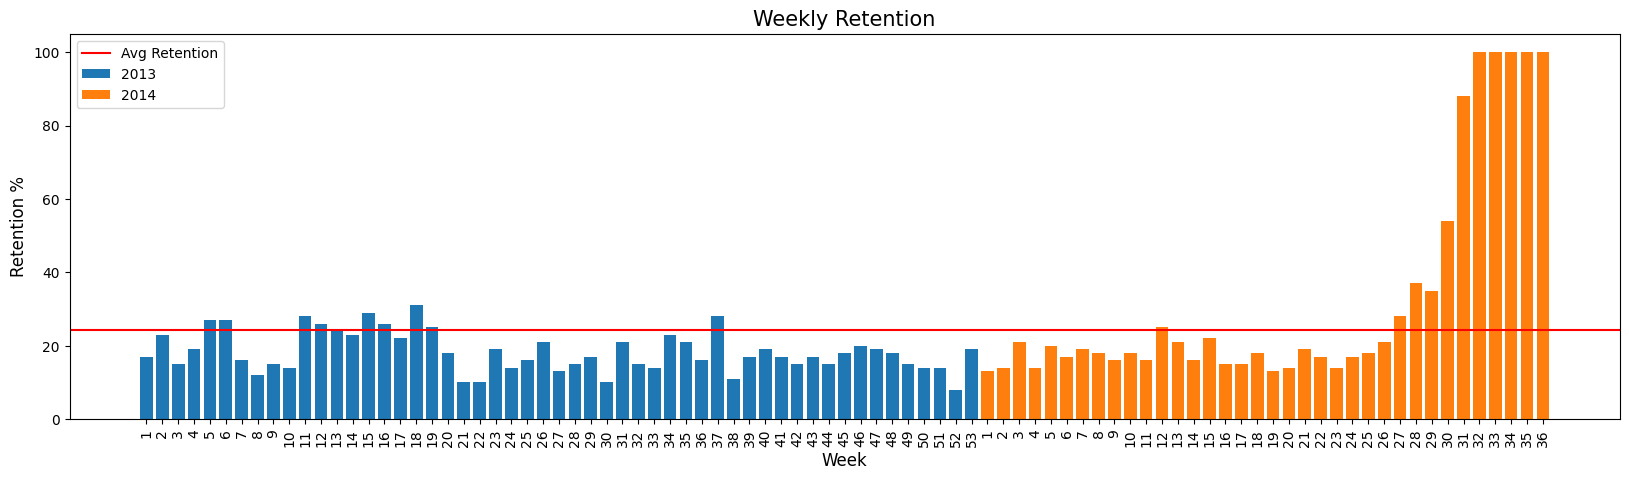

In [51]:
print(f"Average Retention is {round(sql_df['retention_rate'].mean(), 1)} %")

plt.figure(figsize=(20, 5))
plt.title('Weekly Retention', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Retention %', fontsize=12)
plt.bar(sql_df[sql_df['year'] == 2013].index, sql_df[sql_df['year'] == 2013]['retention_rate'], label=2013)
plt.bar(sql_df[sql_df['year'] == 2014].index, sql_df[sql_df['year'] == 2014]['retention_rate'], label=2014)
plt.axhline(sql_df['retention_rate'].mean(), label='Avg Retention', color='r')
plt.xticks(sql_df.index, sql_df['week']+1, rotation=90)
plt.legend()

* Average user retention rate is 24.4 %.
* The values over the last weeks are high as they are close to the month compared to which the retention is calculated.
* The weeks having 100 % retention is same as the month compared to which retention is created.

#### D. Weekly Engagement
* Finding weekly engagement per device.

In [52]:
query = """
    SELECT device, week_num, cnt, ROUND(cnt * 100/(SUM(cnt) OVER (PARTITION BY week_num)), 1) AS per_engagement
    FROM (
        SELECT device, WEEK(occurred_at) AS week_num, COUNT(*) AS cnt
        FROM events
        WHERE event_type = 'engagement'
        GROUP BY device, week_num
        ) a
    ORDER BY device, week_num;
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

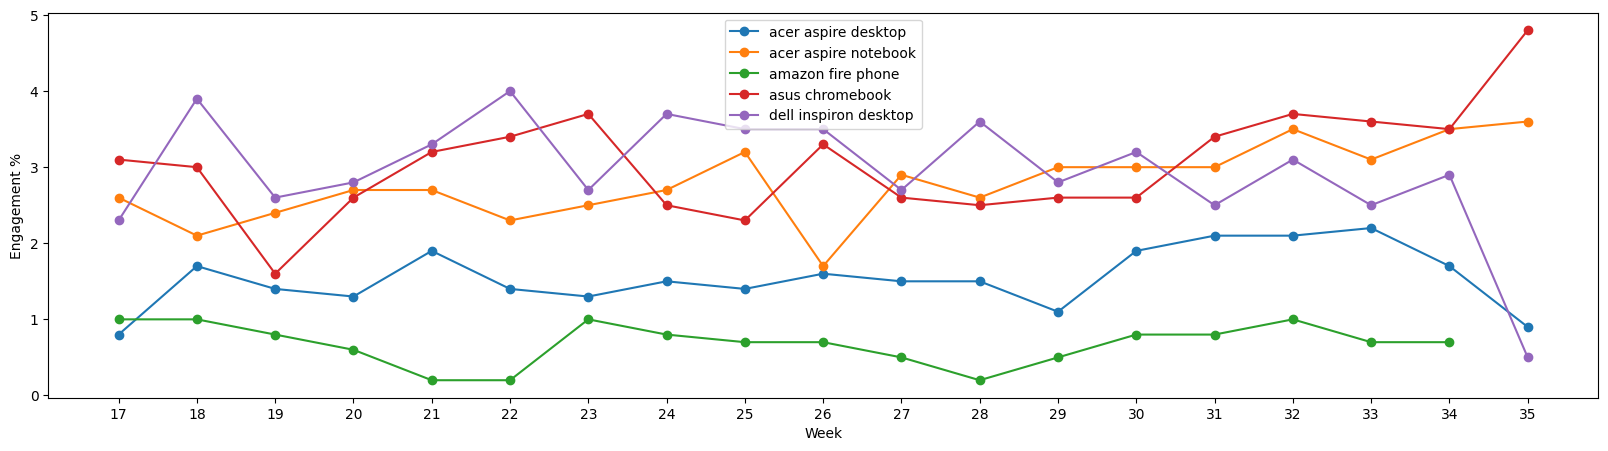

In [67]:
devices = sql_df['device'].unique()
plt.figure(figsize=(20, 5))
plt.xlabel('Week')
plt.ylabel('Engagement %')
plt.xticks(sql_df['week_num'].unique())
for d in devices[:5]:
    data = sql_df[sql_df['device'] == d]
    plt.plot(data['week_num'], data['per_engagement'], label=d, marker='o')
plt.legend()

* Showing the chart for first 5 devices for better visualization.

#### E. Email Engagement
* Calculating the Email engagement metrics.

In [68]:
# Fetching number of opened emails and email clicks per week
query = """
    SELECT
        WEEK(occurred_at) AS week_num,
        SUM(action = 'email_open') AS email_open,
        SUM(action = 'email_clickthrough') AS email_click
    FROM email_events
    group by week_num
"""

sql_df = pd.read_sql_query(sql=query, con=CONNECTION)

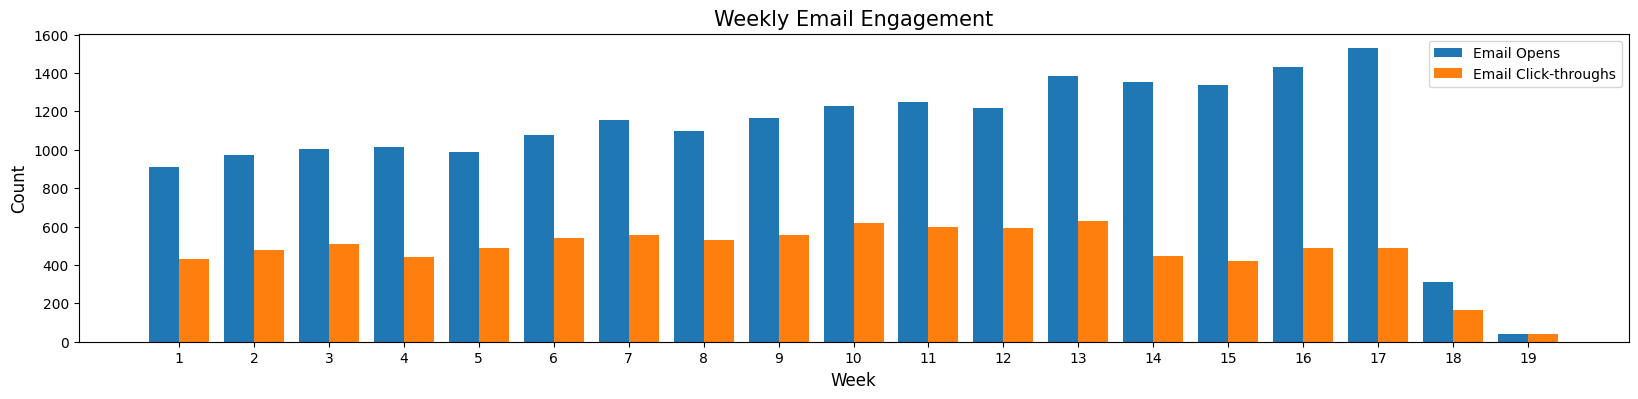

In [72]:
X_axis = np.arange(len(sql_df))
plt.figure(figsize=(20,4))
plt.title('Weekly Email Engagement', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.bar(X_axis-0.2, sql_df['email_open'], 0.4, label='Email Opens')
plt.bar(X_axis+0.2, sql_df['email_click'], 0.4, label='Email Click-throughs')
plt.xticks(X_axis, X_axis+1)
plt.legend()
plt.show()

## CONNECTION CLOSE

Clossing connection to MySql Database

In [ ]:
CURSOR.close()
CONNECTION.close()